# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

# Obtain Data

Read csv file with consumer reports ratings into pandas df

In [2]:
cr_df = pd.read_csv('Data/Ratings.csv')
cr_df = cr_df.iloc[:, range(1, len(cr_df.columns), 2)]
cr_df.columns = [x.replace('.1', '') for x in cr_df.columns]
cr_df['Model'] = cr_df['Model'].apply(lambda x : x.replace('mercedes-benz', 'mercedes benz'))
cr_df['Model'] = cr_df['Model'].apply(lambda x : x.replace('mercedes-amg', 'mercedes amg'))
cr_df['Model'] = cr_df['Model'].apply(lambda x : x.replace('land-rover', 'land rover'))
cr_df['Model'] = cr_df['Model'].apply(lambda x : x.replace('alfa-romeo', 'alfa romeo'))
cr_df['Brand'] = cr_df['Model'].apply(lambda x : x.split('-')[0])
def model_name(row):
    return row['Model'].replace(row['Brand']+'-', '')
cr_df['Model'] = cr_df.apply(model_name, axis=1)
cr_df['Model'] = cr_df['Model'].apply(lambda x : x.replace('-', ' '))
print('cr_df shape: ', cr_df.shape)
cr_df.head()

cr_df shape:  (295, 18)


,Model,Reliability,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand
0,v60,1 / 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,volvo
1,500l,NaN,3 / 5,4 / 5,2 / 5,3 / 5,3 / 5,4 / 5,3 / 5,2 / 5,4 / 5,4 / 5,3 / 5,3 / 5,NaN,3 / 5,860 lb.,fiat
2,xf,NaN,5 / 5,5 / 5,5 / 5,4 / 5,5 / 5,4 / 5,5 / 5,2 / 5,3 / 5,5 / 5,3 / 5,4 / 5,NaN,3 / 5,960 lb.,jaguar
3,tt,NaN,5 / 5,5 / 5,3 / 5,3 / 5,5 / 5,1 / 5,5 / 5,2 / 5,4 / 5,5 / 5,2 / 5,4 / 5,NaN,2 / 5,770 lb.,audi
4,mirai,NaN,3 / 5,3 / 5,4 / 5,4 / 5,4 / 5,3 / 5,4 / 5,2 / 5,5 / 5,2 / 5,4 / 5,3 / 5,NaN,3 / 5,690 lb.,toyota


Read csv file with auto sales data into pandas df

In [3]:
def read_sales_excel(file, column, header):
    sales_df = pd.read_excel(file, header=header)
    sales_df.rename(columns={'Unnamed: 0': 'Model'}, inplace=True)
    sales_df.dropna(subset=[column], inplace=True)
    sales_df = sales_df[['Model', column]]
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('(D)', ''))
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace("(I)", ""))
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace("*", ""))
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace("‡", ""))
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace("†", ""))
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace("Total", ""))
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.strip())
    sales_df['Model'] = sales_df['Model'].apply(lambda x: x.lower())
    sales_df = sales_df.groupby('Model').agg({'Model':'first', column:'max'})
    sales_df.reset_index(inplace=True, drop=True)
    return sales_df
    
    
sales_df = read_sales_excel('Data/Auto_Sales/12-19-auto-sales.xls', '2019.1', 5)
sales_df.rename(columns={'2019.1': 'Sales'}, inplace=True)
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('-', ' '))
sales_df.head()

,Model,Sales
0,2 series,8015.0
1,200,48.0
2,3 series,47827.0
3,300,29213.0
4,370z,2384.0


Reformat sales_df model names to match cr_df model names for merger

In [4]:
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('mazda3', '3'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('mazda6', '6'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('f series', 'f 150'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('silverado', 'silverado 1500'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('ram pickup', '1500'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('discovery/lr4', 'discovery'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('spider', '124'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('e class/cls', 'e class'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('86 (incl. fr s)', '86'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('nautilus/mkx', 'nautilus'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('a4/s4', 'a4'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('a5/s5', 'a5'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('a6/s6', 'a6'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('a7/s7', 'a7'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('a8/s8', 'a8'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('718', '718 boxster'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('countryman', 'cooper countryman'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('cooper s', 'cooper'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('90 series', 's90'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('60 series', 's60'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('370z', 'z'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('sierra', 'sierra 1500'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('slc/slk', 'slc'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('rl/rlx', 'rlx'))
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('glc/glk', 'glc'))
sales_df['Model'] = sales_df['Model'].replace({'gt': 'amg gt'})
sales_df = sales_df[sales_df['Model']!='golf']
sales_df.reset_index(drop=True, inplace=True)
sales_df['Model'] = sales_df['Model'].apply(lambda x: x.replace('golf/golf r/gti', 'golf'))
sales_df.head()

,Model,Sales
0,2 series,8015.0
1,200,48.0
2,3 series,47827.0
3,300,29213.0
4,z,2384.0


Merge sales_df and cr_df dataframes

In [5]:
df = pd.merge(sales_df, cr_df, on='Model')
df.head()

,Model,Sales,Reliability,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand
0,2 series,8015.0,NaN,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,2 / 5,4 / 5,5 / 5,1 / 5,4 / 5,NaN,4 / 5,805 lb.,bmw
1,3 series,47827.0,5 / 5,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,NaN,3 / 5,825 lb.,bmw
2,300,29213.0,5 / 5,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,3 / 5,3 / 5,4 / 5,1 / 5,4 / 5,NaN,4 / 5,865 lb.,chrysler
3,z,2384.0,NaN,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,NaN,5 / 5,1 / 5,3 / 5,5 / 5,4 / 5,2 / 5,NaN,4 / 5,450 lb.,nissan
4,4 series,18621.0,5 / 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,790 lb.,bmw


# Scrub Data

Use df.info to determine what scrubbing needed 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 262 entries, 0 to 261
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Model                    262 non-null    object 
 1   Sales                    262 non-null    float64
 2   Reliability              133 non-null    object 
 3   Acceleration             227 non-null    object 
 4   Braking                  227 non-null    object 
 5   Ride                     227 non-null    object 
 6   Noise                    227 non-null    object 
 7   Front Seat Comfort       227 non-null    object 
 8   Rear Seat Comfort        221 non-null    object 
 9   Interior Fit and Finish  227 non-null    object 
 10  Trunk/Cargo Area         227 non-null    object 
 11  Fuel Economy             227 non-null    object 
 12  Routine Handling         227 non-null    object 
 13  Headlights               227 non-null    object 
 14  Driving Position         2

Drop rows missing most or all ratings data

In [7]:
df = df[df.isna().sum(axis=1)<9]
df.head()

,Model,Sales,Reliability,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand
0,2 series,8015.0,NaN,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,2 / 5,4 / 5,5 / 5,1 / 5,4 / 5,NaN,4 / 5,805 lb.,bmw
1,3 series,47827.0,5 / 5,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,NaN,3 / 5,825 lb.,bmw
2,300,29213.0,5 / 5,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,3 / 5,3 / 5,4 / 5,1 / 5,4 / 5,NaN,4 / 5,865 lb.,chrysler
3,z,2384.0,NaN,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,NaN,5 / 5,1 / 5,3 / 5,5 / 5,4 / 5,2 / 5,NaN,4 / 5,450 lb.,nissan
6,4runner,131888.0,4 / 5,4 / 5,4 / 5,2 / 5,4 / 5,4 / 5,4 / 5,3 / 5,4 / 5,2 / 5,2 / 5,4 / 5,3 / 5,NaN,4 / 5,1155 lb.,toyota


Drop Reliability feature due to large amount of missing data

In [8]:
df.drop(columns='Reliability', inplace=True)
df.head()

,Model,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand
0,2 series,8015.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,2 / 5,4 / 5,5 / 5,1 / 5,4 / 5,NaN,4 / 5,805 lb.,bmw
1,3 series,47827.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,NaN,3 / 5,825 lb.,bmw
2,300,29213.0,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,3 / 5,3 / 5,4 / 5,1 / 5,4 / 5,NaN,4 / 5,865 lb.,chrysler
3,z,2384.0,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,NaN,5 / 5,1 / 5,3 / 5,5 / 5,4 / 5,2 / 5,NaN,4 / 5,450 lb.,nissan
6,4runner,131888.0,4 / 5,4 / 5,2 / 5,4 / 5,4 / 5,4 / 5,3 / 5,4 / 5,2 / 5,2 / 5,4 / 5,3 / 5,NaN,4 / 5,1155 lb.,toyota


Update Max. Load column to integer data type

In [9]:
df['Max. Load'] = df['Max. Load'].apply(lambda x: int(x.replace(' lb.', '')))
df.head()

,Model,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand
0,2 series,8015.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,2 / 5,4 / 5,5 / 5,1 / 5,4 / 5,NaN,4 / 5,805,bmw
1,3 series,47827.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,NaN,3 / 5,825,bmw
2,300,29213.0,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,3 / 5,3 / 5,4 / 5,1 / 5,4 / 5,NaN,4 / 5,865,chrysler
3,z,2384.0,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,NaN,5 / 5,1 / 5,3 / 5,5 / 5,4 / 5,2 / 5,NaN,4 / 5,450,nissan
6,4runner,131888.0,4 / 5,4 / 5,2 / 5,4 / 5,4 / 5,4 / 5,3 / 5,4 / 5,2 / 5,2 / 5,4 / 5,3 / 5,NaN,4 / 5,1155,toyota


Replace missing Rear Seat Comfort and Third Seat Comfort values with 0

In [10]:
rating_replace_dict = {np.nan: '0 / 5'}
df['Rear Seat Comfort'] = df['Rear Seat Comfort'].replace(rating_replace_dict)
df['Third Seat Comfort'] = df['Third Seat Comfort'].replace(rating_replace_dict)
df.head()

,Model,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand
0,2 series,8015.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,2 / 5,4 / 5,5 / 5,1 / 5,4 / 5,0 / 5,4 / 5,805,bmw
1,3 series,47827.0,5 / 5,5 / 5,3 / 5,4 / 5,5 / 5,3 / 5,5 / 5,3 / 5,4 / 5,5 / 5,2 / 5,4 / 5,0 / 5,3 / 5,825,bmw
2,300,29213.0,4 / 5,4 / 5,4 / 5,5 / 5,5 / 5,5 / 5,5 / 5,3 / 5,3 / 5,4 / 5,1 / 5,4 / 5,0 / 5,4 / 5,865,chrysler
3,z,2384.0,5 / 5,5 / 5,2 / 5,2 / 5,4 / 5,0 / 5,5 / 5,1 / 5,3 / 5,5 / 5,4 / 5,2 / 5,0 / 5,4 / 5,450,nissan
6,4runner,131888.0,4 / 5,4 / 5,2 / 5,4 / 5,4 / 5,4 / 5,3 / 5,4 / 5,2 / 5,2 / 5,4 / 5,3 / 5,0 / 5,4 / 5,1155,toyota


Update ratings columns to integer data type

In [11]:
ratings_columns = list(df.columns)
ratings_columns.remove('Model')
ratings_columns.remove('Sales')
ratings_columns.remove('Max. Load')
ratings_columns.remove('Brand')

for col in ratings_columns:
    df[col] = df[col].apply(lambda x: int(x[0]))
df.head()

,Model,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Brand
0,2 series,8015.0,5,5,3,4,5,2,4,2,4,5,1,4,0,4,805,bmw
1,3 series,47827.0,5,5,3,4,5,3,5,3,4,5,2,4,0,3,825,bmw
2,300,29213.0,4,4,4,5,5,5,5,3,3,4,1,4,0,4,865,chrysler
3,z,2384.0,5,5,2,2,4,0,5,1,3,5,4,2,0,4,450,nissan
6,4runner,131888.0,4,4,2,4,4,4,3,4,2,2,4,3,0,4,1155,toyota


Drop object columns not useful for modeling

In [12]:
df.drop(columns=['Model', 'Brand'], inplace=True)
df.head()

,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load
0,8015.0,5,5,3,4,5,2,4,2,4,5,1,4,0,4,805
1,47827.0,5,5,3,4,5,3,5,3,4,5,2,4,0,3,825
2,29213.0,4,4,4,5,5,5,5,3,3,4,1,4,0,4,865
3,2384.0,5,5,2,2,4,0,5,1,3,5,4,2,0,4,450
6,131888.0,4,4,2,4,4,4,3,4,2,2,4,3,0,4,1155


Confirm data scrubbed with df.info

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 227 entries, 0 to 261
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Sales                    227 non-null    float64
 1   Acceleration             227 non-null    int64  
 2   Braking                  227 non-null    int64  
 3   Ride                     227 non-null    int64  
 4   Noise                    227 non-null    int64  
 5   Front Seat Comfort       227 non-null    int64  
 6   Rear Seat Comfort        227 non-null    int64  
 7   Interior Fit and Finish  227 non-null    int64  
 8   Trunk/Cargo Area         227 non-null    int64  
 9   Fuel Economy             227 non-null    int64  
 10  Routine Handling         227 non-null    int64  
 11  Headlights               227 non-null    int64  
 12  Driving Position         227 non-null    int64  
 13  Third Seat Comfort       227 non-null    int64  
 14  Usability                2

# Explore Data

Identify outliers with isolation forest model

In [14]:
isf_x = df.drop(columns=['Sales'])
isf_y = df['Sales']
isf_xtrain, isf_xtest, isf_ytrain, isf_ytest = train_test_split(isf_x, isf_y,random_state=71)

isf_ss = StandardScaler()
isf_ss.fit(isf_xtrain)
ss_isf_xtrain = pd.DataFrame(isf_ss.transform(isf_xtrain), columns=isf_xtrain.columns, index=isf_xtrain.index)

isf = IsolationForest(contamination=.05)
ss_isf_xtrain['Outlier'] = isf.fit_predict(ss_isf_xtrain)
ss_isf_xtrain[ss_isf_xtrain['Outlier']==-1].round(1)

,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load,Outlier
216,0.1,0.9,-1.5,-2.8,-1.4,-2.8,-1.2,-1.9,1.5,1.5,0.2,-2.6,-0.4,-0.6,-2.5,-1
154,0.1,0.9,-1.5,-2.8,-1.4,-2.8,-1.2,-1.9,1.5,1.5,0.2,-2.6,-0.4,-0.6,-2.5,-1
3,1.5,0.9,-1.5,-1.8,-0.0,-2.8,1.2,-1.9,-0.2,1.5,1.4,-2.6,-0.4,0.3,-2.0,-1
8,0.1,0.9,-2.6,-1.8,-1.4,-2.0,-1.2,-1.9,0.7,1.5,1.4,-1.0,-0.4,-0.6,-1.1,-1
149,1.5,-0.3,-1.5,-0.8,1.3,-1.2,-0.0,0.1,1.5,1.5,1.4,0.6,-0.4,-2.4,-0.3,-1
222,0.1,-2.8,-1.5,-1.8,-2.8,-1.2,-2.5,0.1,-1.0,-2.2,0.2,-2.6,-0.4,0.3,0.1,-1
144,-2.7,-1.6,-0.4,-2.8,-1.4,-0.4,-3.7,-0.9,1.5,-2.2,-0.9,-2.6,-0.4,0.3,-0.6,-1
261,1.5,0.9,-2.6,-1.8,1.3,-2.8,1.2,-0.9,0.7,1.5,-0.9,-1.0,-0.4,-0.6,-2.0,-1
88,0.1,-2.8,-1.5,1.3,-0.0,1.2,-1.2,2.1,-1.0,-2.2,-0.9,0.6,-0.4,0.3,2.0,-1


Calculate descriptive statistics for each feature

In [15]:
df.describe().iloc[:, 0:10].round(1)

,Sales,Acceleration,Braking,Ride,Noise,Front Seat Comfort,Rear Seat Comfort,Interior Fit and Finish,Trunk/Cargo Area,Fuel Economy
count,227.0,227.0,227.0,227.0,227.0,227.0,227.0,227.0,227.0,227.0
mean,71108.3,3.9,4.2,3.4,3.8,4.0,3.5,4.0,2.9,3.2
std,108049.6,0.7,0.8,0.9,0.9,0.8,1.2,0.8,1.0,1.2
min,771.0,2.0,1.0,1.0,1.0,2.0,0.0,1.0,1.0,1.0
25%,13915.0,4.0,4.0,3.0,3.0,4.0,3.0,3.0,2.0,2.0
50%,31987.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,3.0,3.0
75%,88372.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,3.5,4.0
max,896526.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0,5.0


In [16]:
df.describe().iloc[:, 10:].round(1)

,Routine Handling,Headlights,Driving Position,Third Seat Comfort,Usability,Max. Load
count,227.0,227.0,227.0,227.0,227.0,227.0
mean,3.7,2.8,3.6,0.3,3.7,993.5
std,0.8,0.9,0.6,0.8,1.1,259.4
min,2.0,1.0,2.0,0.0,1.0,340.0
25%,3.0,2.0,3.0,0.0,3.0,850.0
50%,4.0,3.0,4.0,0.0,4.0,905.0
75%,4.0,3.0,4.0,0.0,5.0,1107.5
max,5.0,5.0,5.0,3.0,5.0,1940.0


Plot distribution for each feature

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


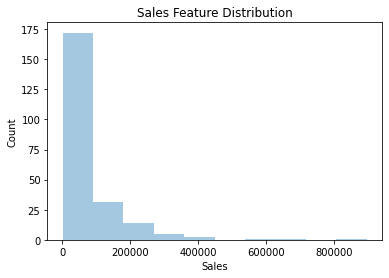

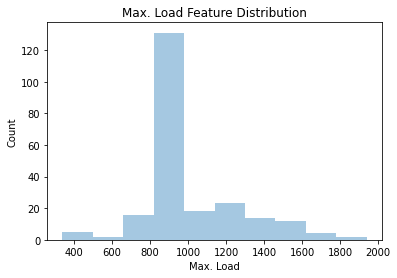

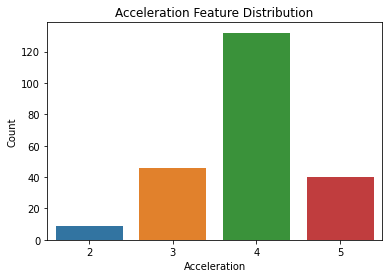

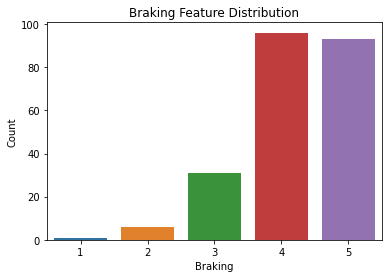

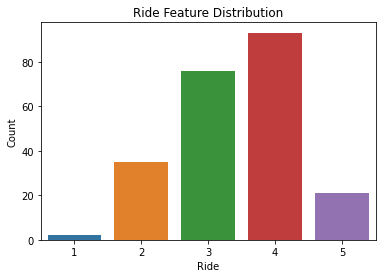

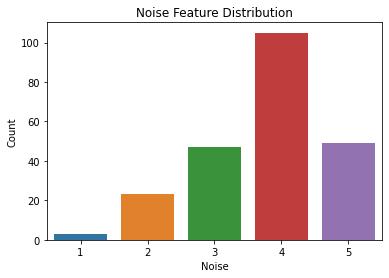

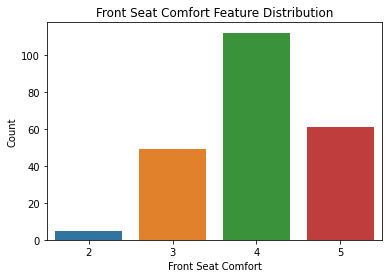

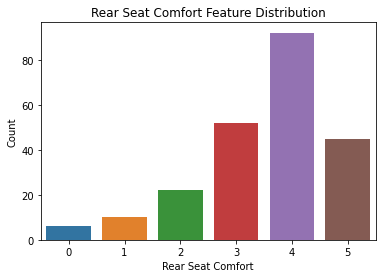

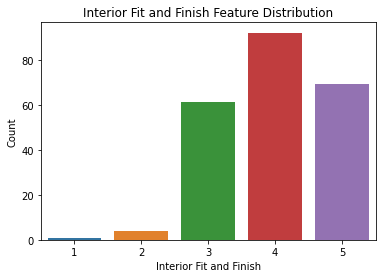

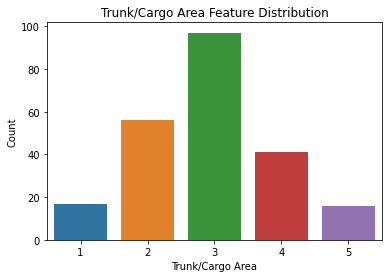

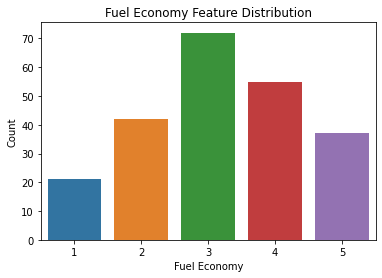

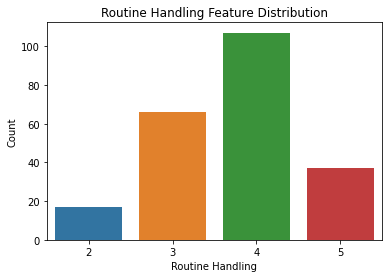

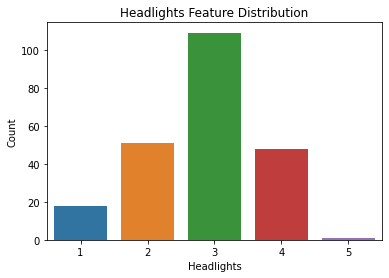

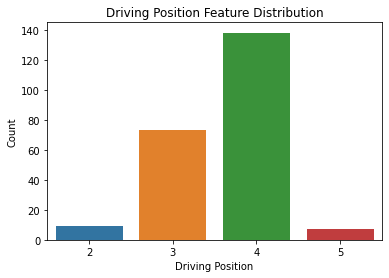

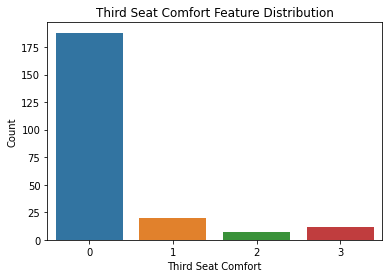

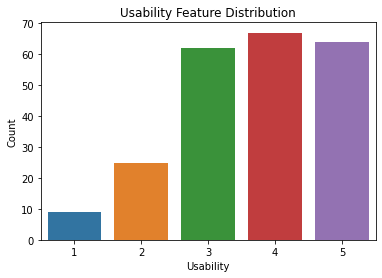

In [17]:
dist_columns = ['Sales', 'Max. Load']
other_columns = list(df.columns)
for dist_col in dist_columns:
    other_columns.remove(dist_col)
    
for col in dist_columns:
    fig, ax=plt.subplots()
    sns.distplot(df[col], bins=10, ax=ax, kde=False)
    ax.set_title(f'{col} Feature Distribution')
    ax.set_ylabel('Count')

for col in other_columns:
    fig, ax=plt.subplots()
    sns.countplot(x=col, data=df, ax=ax)
    ax.set_title(f'{col} Feature Distribution')
    ax.set_ylabel('Count')

Plot relationship of each feature to the dependent variable

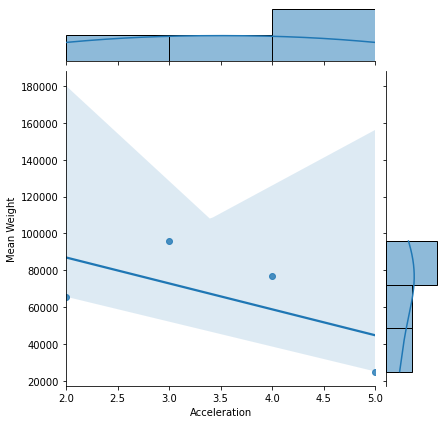

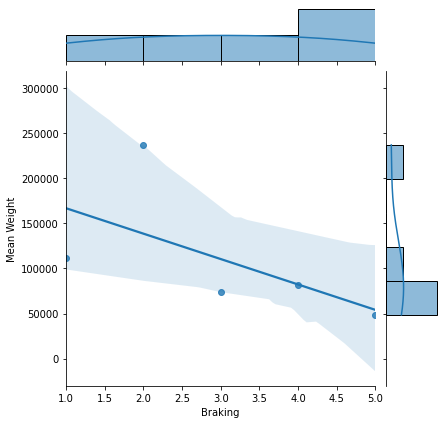

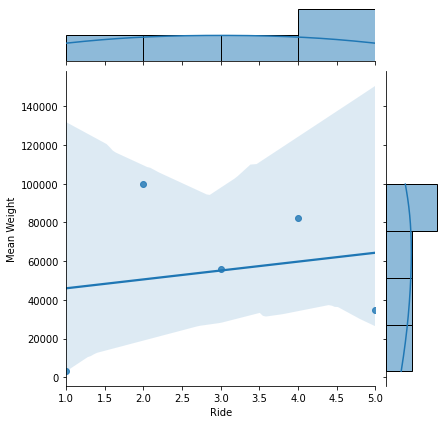

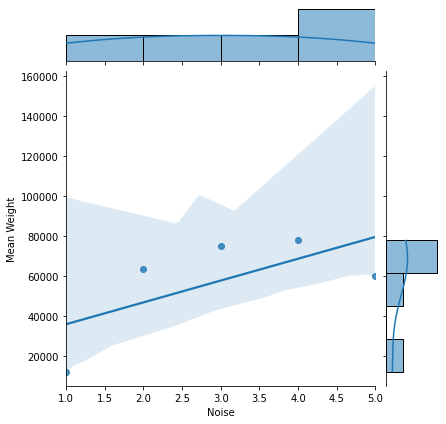

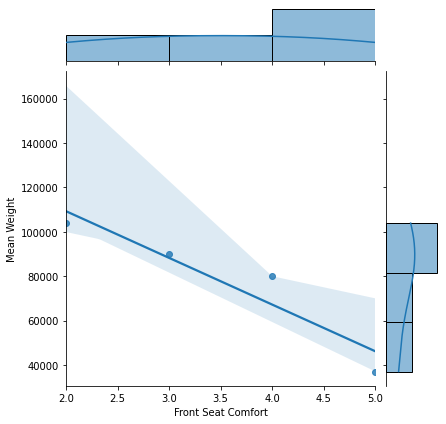

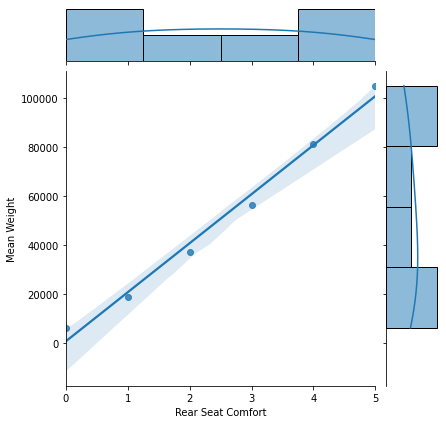

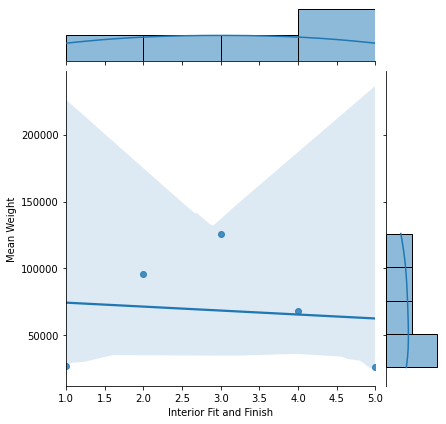

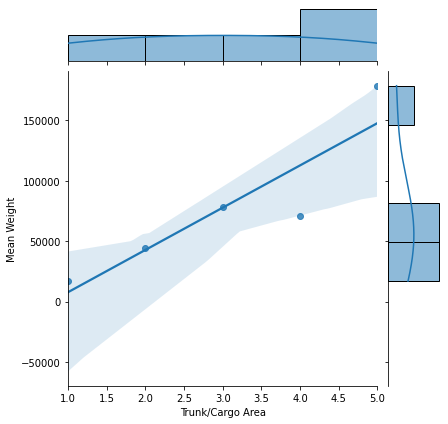

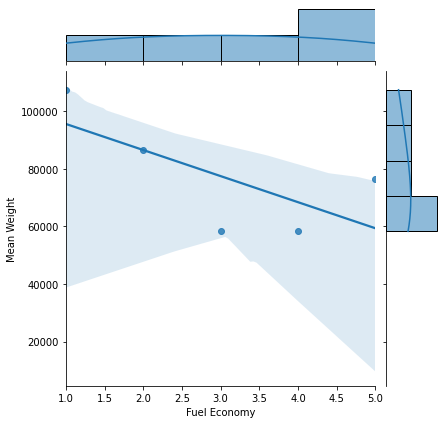

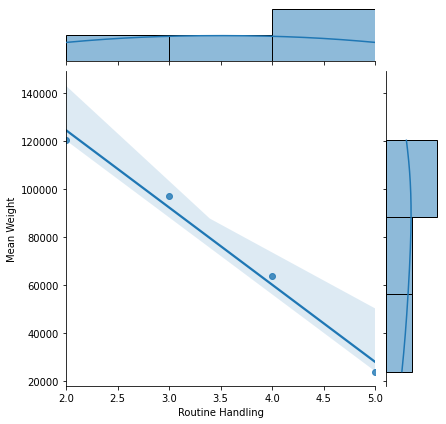

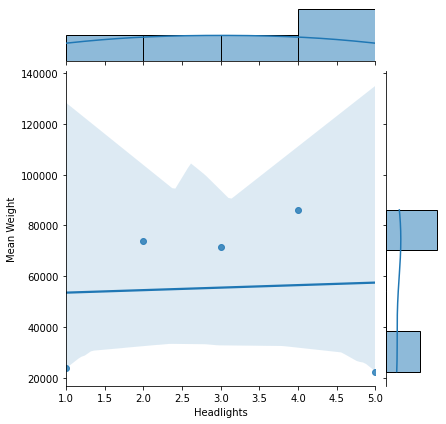

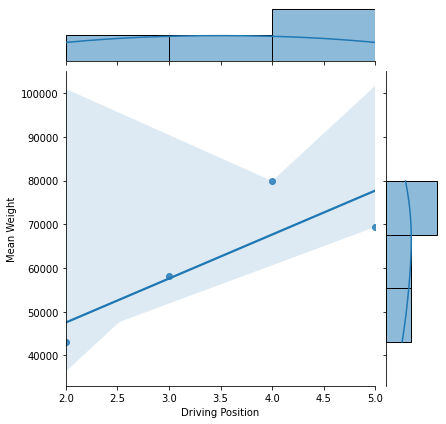

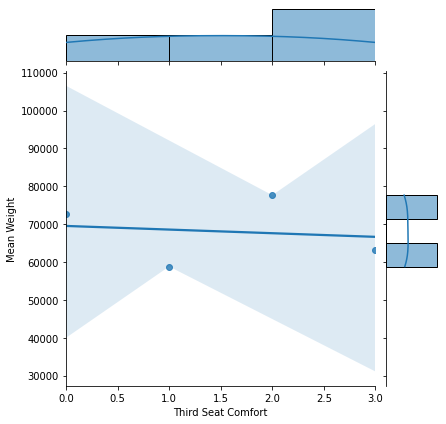

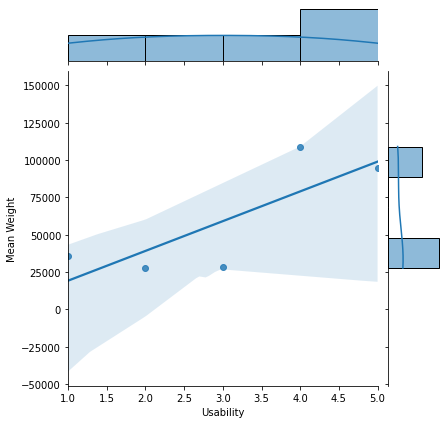

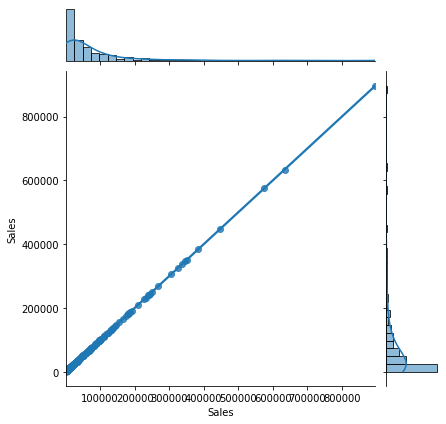

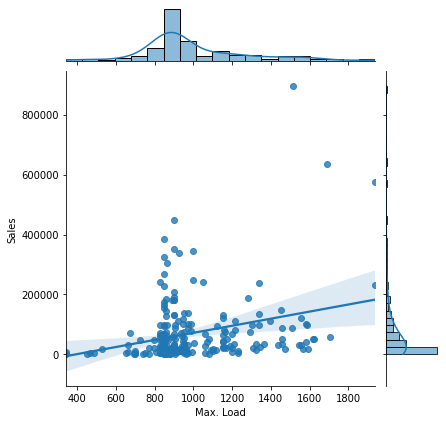

In [18]:
for col in other_columns:
    joint_df = df.groupby(col).mean().reset_index()
    plot = sns.jointplot(x=col, y='Sales', data=joint_df, kind='reg')
    plot.ax_joint.set_ylabel('Mean Weight')

    
for col in dist_columns:
    sns.jointplot(x=col, y='Sales', data=df, kind='reg', ax=ax)

Use vif to find heavily correlated features

In [19]:
vif_x = df.drop(columns=['Sales'])
vif_y = df['Sales']
vif_x_train, vif_x_test, vif_y_train, vif_y_test = train_test_split(vif_x, vif_y, random_state=71)

vif_df = add_constant(vif_x_train)
vif_output = []
for num in range(0, len(vif_df.columns)):
    vif_output.append([vif_df.columns[num], variance_inflation_factor(vif_df.values, num)])
vif_output_df = pd.DataFrame(vif_output, columns=['Column', 'VIF'])
vif_output_df.sort_values(by='VIF', ascending=False, inplace=True)
vif_output_df.reset_index(drop=True, inplace=True)
vif_output_df.round(1)

,Column,VIF
0,const,258.0
1,Noise,4.7
2,Interior Fit and Finish,3.6
3,Max. Load,3.0
4,Rear Seat Comfort,2.6
5,Front Seat Comfort,2.5
6,Ride,2.4
7,Fuel Economy,2.3
8,Routine Handling,2.1
9,Trunk/Cargo Area,2.1


Calculate correlation for all features

<AxesSubplot:>

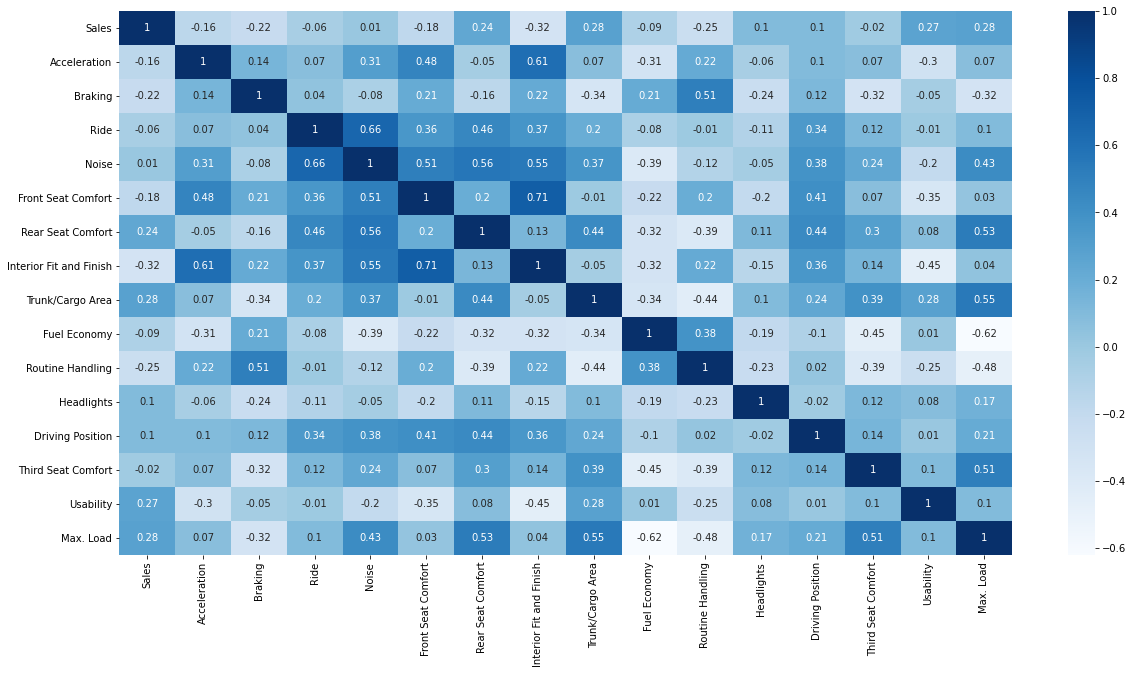

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(df.corr().round(2), annot=True, cmap='Blues', ax=ax)

# Model Data